In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataframe train

In [1]:
from google.colab import files
data_to_load = files.upload()

Saving plant_disease.csv to plant_disease.csv


In [5]:
import pandas as pd

plant_disease = pd.read_csv('plant_disease.csv')

plant_disease.head()

,img_path,species_name,is_infected,disease_name
0,/content/drive/MyDrive/Dataset_projet/Maladie ...,Apple,True,Apple_scab
1,/content/drive/MyDrive/Dataset_projet/Maladie ...,Apple,True,Apple_scab
2,/content/drive/MyDrive/Dataset_projet/Maladie ...,Apple,True,Apple_scab
3,/content/drive/MyDrive/Dataset_projet/Maladie ...,Apple,True,Apple_scab
4,/content/drive/MyDrive/Dataset_projet/Maladie ...,Apple,True,Apple_scab


In [ ]:
plant_disease.shape

(70295, 4)

In [ ]:
num_classes1 = len(plant_disease.disease_name.unique())
print(num_classes1)

21


In [ ]:
plant_disease["disease_name"] = plant_disease["disease_name"].astype(str)

# Dataframe validation

In [2]:
from google.colab import files
data_to_load = files.upload()

Saving df_valid.csv to df_valid.csv


In [4]:
import pandas as pd

df_valid = pd.read_csv('df_valid.csv')

df_valid.head()

,filepath,species_name,is_infected,disease_name
0,/content/drive/MyDrive/Dataset_projet/Maladie ...,Apple,True,Black_rot
1,/content/drive/MyDrive/Dataset_projet/Maladie ...,Apple,True,Black_rot
2,/content/drive/MyDrive/Dataset_projet/Maladie ...,Apple,True,Black_rot
3,/content/drive/MyDrive/Dataset_projet/Maladie ...,Apple,True,Black_rot
4,/content/drive/MyDrive/Dataset_projet/Maladie ...,Apple,True,Black_rot


In [10]:
df_valid.shape

(16973, 4)

In [11]:
num_classes2 = len(df_valid.disease_name.unique())
print(num_classes2)

21


In [ ]:
df_valid["disease_name"] = df_valid["disease_name"].astype(str)

# Pré-traitement des données

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

train_generator = datagen.flow_from_dataframe(
    dataframe=plant_disease,
    x_col="img_path",
    y_col="disease_name",
    target_size=(256, 256),
    batch_size=64,
    subset='training',
    class_mode='categorical'
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=df_valid,
    x_col="filepath",
    y_col="disease_name",
    target_size=(256, 256),
    batch_size=64,
    #subset='validation',
    class_mode='categorical',
    shuffle=False
)

Found 70295 validated image filenames belonging to 21 classes.
Found 16973 validated image filenames belonging to 21 classes.


# Modélisation

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam


# Charger le modèle pré-entraîné (VGG16)
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


for layer in vgg16.layers:
    layer.trainable = False

vgg16.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [ ]:
model = Sequential()
model.add(vgg16)

# Ajouter les couches supplémentaires au modèle

model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                        

In [ ]:
# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras import callbacks

# Définir les callbacks
# Sauvegarder les meilleurs poids du modèle au cours de l'entraînement :

checkpoint = callbacks.ModelCheckpoint(filepath = '/content/drive/MyDrive/Projet_Reconnaissance_Plantes/5.Modélisation_Deep_learning/Transfer learning/disease_name/2.weight_vgg16.h5',
                                       monitor = 'val_loss',
                                       save_best_only = True,
                                       save_weights_only = False,
                                       mode = 'min',
                                       save_freq = 'epoch')

# Réduire automatiquement le learning rate
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                         patience = 5,
                                         factor = 0.5,
                                         verbose = 2,
                                         mode = 'min')

# Arrêter l'entraînement si le modèle n'évolue plus (évite de gérer le nombre d'epoch)
early_stopping = callbacks.EarlyStopping(monitor='val_loss',
                                        patience=8,
                                        mode='min',
                                        restore_best_weights=True)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=15,
    callbacks=[checkpoint, early_stopping, lr_plateau]
)

Epoch 1/15
1098/1098 [==============================] - 391s 356ms/step - loss: 0.0703 - accuracy: 0.9802 - val_loss: 0.0851 - val_accuracy: 0.9754 - lr: 0.0010
Epoch 2/15
1098/1098 [==============================] - 388s 353ms/step - loss: 0.0683 - accuracy: 0.9801 - val_loss: 0.0794 - val_accuracy: 0.9763 - lr: 0.0010
Epoch 3/15
1098/1098 [==============================] - 387s 353ms/step - loss: 0.0629 - accuracy: 0.9818 - val_loss: 0.0770 - val_accuracy: 0.9778 - lr: 0.0010
Epoch 4/15
1098/1098 [==============================] - 387s 352ms/step - loss: 0.0604 - accuracy: 0.9822 - val_loss: 0.0747 - val_accuracy: 0.9790 - lr: 0.0010
Epoch 5/15
1098/1098 [==============================] - 396s 361ms/step - loss: 0.0558 - accuracy: 0.9841 - val_loss: 0.0647 - val_accuracy: 0.9823 - lr: 0.0010
Epoch 6/15
1098/1098 [==============================] - 401s 365ms/step - loss: 0.0553 - accuracy: 0.9841 - val_loss: 0.1040 - val_accuracy: 0.9705 - lr: 0.0010
Epoch 7/15
1098/1098 [============

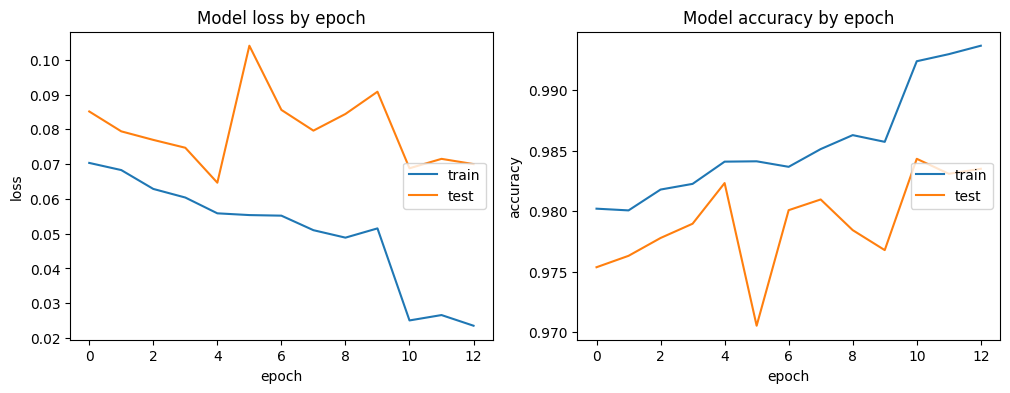

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='right')
plt.show()

In [ ]:
# Sauvegarde du modèle

model.save('/content/drive/MyDrive/Projet_Reconnaissance_Plantes/5.Modélisation_Deep_learning/Transfer learning/disease_name/2.model_tl_vgg16_disease_name_full.h5')

# Evaluation

In [ ]:
import numpy as np

predictions = model.predict(valid_generator)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = valid_generator.classes
class_labels = valid_generator.class_indices

266/266 [==============================] - 77s 290ms/step


Accuracy : 98.23%


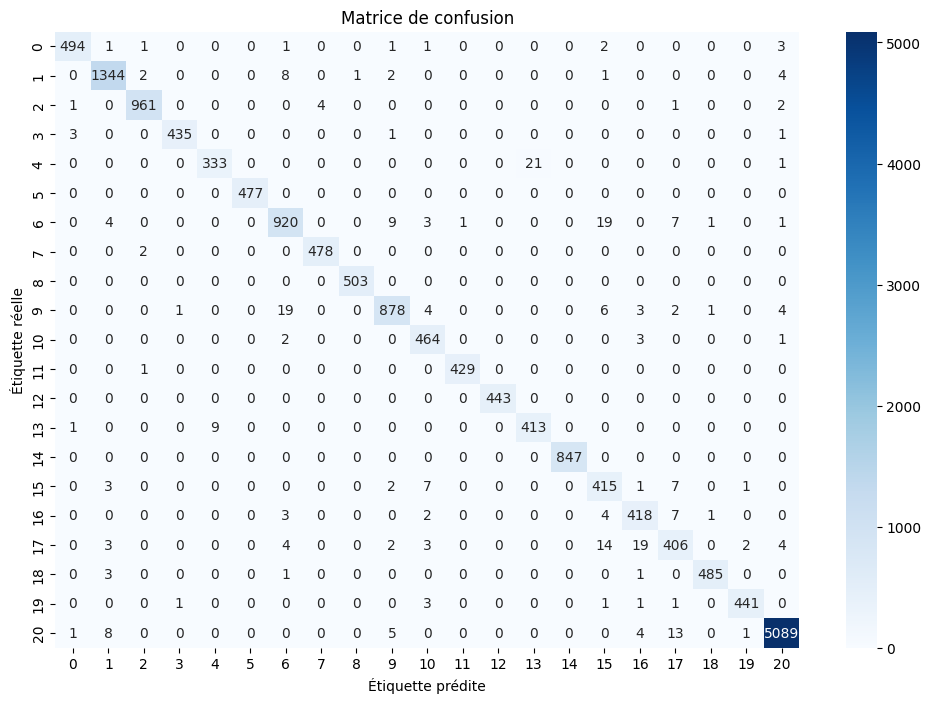

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy : {:.2f}%".format(accuracy * 100))


confusion = confusion_matrix(true_labels, predicted_labels)

class_labels = np.unique(true_labels)

plt.figure(figsize=(12, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Matrice de confusion")
plt.xlabel("Étiquette prédite")
plt.ylabel("Étiquette réelle")
plt.show()

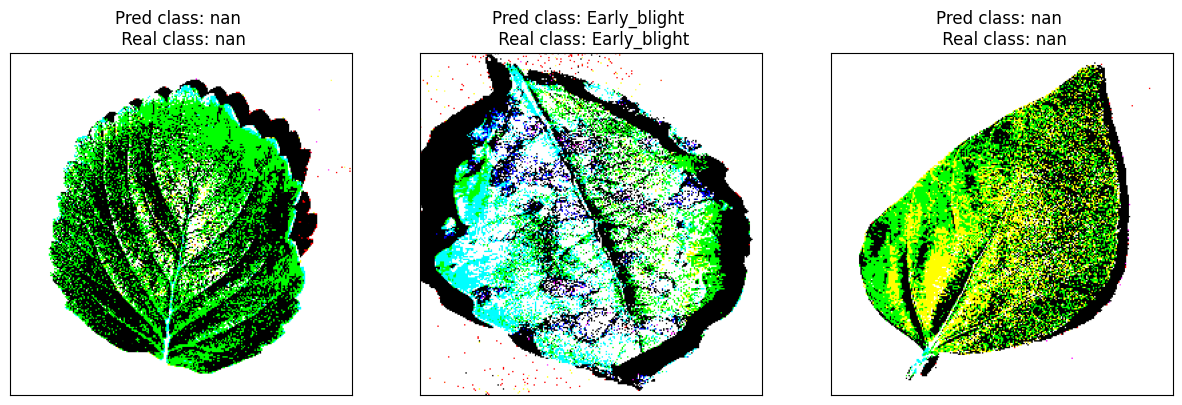

In [ ]:
import tensorflow as tf

indices_random = tf.random.uniform([3], 0, len(valid_generator), dtype=tf.int32)

plt.figure(figsize=(15, 7))
for i, idx in enumerate(indices_random):
    # Charger un batch d'images et de prédictions
    batch_images, batch_labels = valid_generator[idx]

    # Sélectionner une image aléatoire dans le batch
    image = batch_images[0]
    pred_class_index = tf.argmax(batch_labels[0])

    plt.subplot(1, 3, i+1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    pred_class = valid_generator.class_indices
    pred_class = dict((v, k) for k, v in pred_class.items())  # Inverser le dictionnaire

    #real_class = pred_generator.classes[idx * pred_generator.batch_size]

    real_class_index = valid_generator.classes[idx * valid_generator.batch_size]
    real_class = pred_class[int(real_class_index)]

    plt.title('Pred class: {} \n Real class: {}'.format(pred_class[int(pred_class_index)], real_class))

plt.show()

### Vérification que les NaN correspondent à la classe healthy

In [6]:
print(plant_disease["disease_name"].isna().sum())
print(plant_disease["disease_name"].unique())

22294
['Apple_scab' 'Black_rot' 'Cercospora_leaf_spot Gray_leaf_spot'
 'Common_rust_' 'Northern_Leaf_Blight' nan
 'Leaf_blight_(Isariopsis_Leaf_Spot)' 'Esca_(Black_Measles)'
 'Powdery_mildew' 'Haunglongbing_(Citrus_greening)' 'Bacterial_spot'
 'Early_blight' 'Late_blight' 'Spider_mites Two-spotted_spider_mite'
 'Leaf_scorch' 'Septoria_leaf_spot' 'Leaf_Mold' 'Tomato_mosaic_virus'
 'Target_Spot' 'Cedar_apple_rust' 'Tomato_Yellow_Leaf_Curl_Virus']


In [7]:
plant_disease.loc[plant_disease['is_infected'] == False, 'disease_name'] = 'healthy'
print((plant_disease["disease_name"] == "healthy").sum())
print(plant_disease["disease_name"].unique())

22294
['Apple_scab' 'Black_rot' 'Cercospora_leaf_spot Gray_leaf_spot'
 'Common_rust_' 'Northern_Leaf_Blight' 'healthy'
 'Leaf_blight_(Isariopsis_Leaf_Spot)' 'Esca_(Black_Measles)'
 'Powdery_mildew' 'Haunglongbing_(Citrus_greening)' 'Bacterial_spot'
 'Early_blight' 'Late_blight' 'Spider_mites Two-spotted_spider_mite'
 'Leaf_scorch' 'Septoria_leaf_spot' 'Leaf_Mold' 'Tomato_mosaic_virus'
 'Target_Spot' 'Cedar_apple_rust' 'Tomato_Yellow_Leaf_Curl_Virus']


In [8]:
print(df_valid["disease_name"].isna().sum())
print(df_valid["disease_name"].unique())

5121
['Black_rot' 'Cedar_apple_rust' 'Apple_scab' nan 'Northern_Leaf_Blight'
 'Powdery_mildew' 'Cercospora_leaf_spot Gray_leaf_spot' 'Common_rust_'
 'Esca_(Black_Measles)' 'Leaf_blight_(Isariopsis_Leaf_Spot)'
 'Bacterial_spot' 'Late_blight' 'Early_blight'
 'Haunglongbing_(Citrus_greening)' 'Leaf_scorch' 'Septoria_leaf_spot'
 'Tomato_mosaic_virus' 'Spider_mites Two-spotted_spider_mite' 'Leaf_Mold'
 'Target_Spot' 'Tomato_Yellow_Leaf_Curl_Virus']


In [9]:
df_valid.loc[df_valid['is_infected'] == False, 'disease_name'] = 'healthy'
print((df_valid["disease_name"] == "healthy").sum())
print(df_valid["disease_name"].unique())

5121
['Black_rot' 'Cedar_apple_rust' 'Apple_scab' 'healthy'
 'Northern_Leaf_Blight' 'Powdery_mildew'
 'Cercospora_leaf_spot Gray_leaf_spot' 'Common_rust_'
 'Esca_(Black_Measles)' 'Leaf_blight_(Isariopsis_Leaf_Spot)'
 'Bacterial_spot' 'Late_blight' 'Early_blight'
 'Haunglongbing_(Citrus_greening)' 'Leaf_scorch' 'Septoria_leaf_spot'
 'Tomato_mosaic_virus' 'Spider_mites Two-spotted_spider_mite' 'Leaf_Mold'
 'Target_Spot' 'Tomato_Yellow_Leaf_Curl_Virus']


In [ ]:
# Les NaN correspondent bien à la classe 'healthy'